In [1]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

import random, os
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
import pandas as pd
import copy


from fedlab.utils.dataset import FMNISTPartitioner,CIFAR10Partitioner
from fedlab.utils.functional import partition_report, save_dict
    
from args_cifar10_c2 import args_parser
import server_se1 as server
import model

from utils.global_test import test_on_globaldataset, globalmodel_test_on_localdataset,globalmodel_test_on_specifdataset
from utils.local_test import test_on_localdataset
from utils.training_loss import train_loss_show,train_localacc_show
from utils.sampling import testset_sampling, trainset_sampling, trainset_sampling_label
from utils.tSNE import FeatureVisualize

args = args_parser()

def seed_torch(seed=args.seed):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed)
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True

seed_torch()
GLOBAL_SEED = 1
def worker_init_fn(worker_id):
    global GLOBAL_WORKER_ID
    GLOBAL_WORKER_ID = worker_id
    set_seed(GLOBAL_SEED + worker_id)

similarity = False
save_models = False
Train_model = True

In [2]:
C = "2CNN_2" 

In [3]:
specf_model = model.Client_Model(args, name='cifar10').to(args.device)

In [6]:
trans_cifar10 =  transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.491, 0.482, 0.447], 
                                                        std=[0.247, 0.243, 0.262])])
root = "data/CIFAR10/"
trainset = torchvision.datasets.CIFAR10(root=root,train=True, download=True, transform=trans_cifar10)
testset = torchvision.datasets.CIFAR10(root=root,train=False, download=True, transform=trans_cifar10)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/CIFAR10/cifar-10-python.tar.gz to data/CIFAR10/
Files already downloaded and verified


In [5]:
num_classes = args.num_classes
num_clients = args.K
number_perclass = args.num_perclass
 

col_names = [f"class{i}" for i in range(num_classes)]
print(col_names)
hist_color = '#4169E1'
plt.rcParams['figure.facecolor'] = 'white'

['class0', 'class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9']


In [6]:
### Distribution-based (class)

12:32:35 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
12:32:35 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


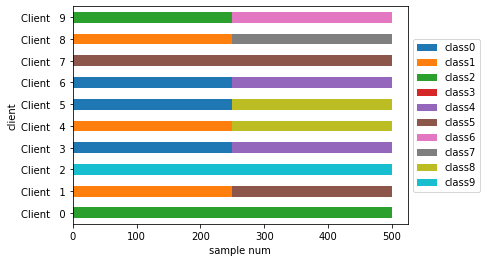

In [7]:
# perform partition
noniid_labeldir_part = CIFAR10Partitioner(trainset.targets, 
                                num_clients=num_clients,
                                balance=None, 
                                partition="shards",
                                num_shards=200,
                                seed=1)
# generate partition report
csv_file = "data/CIFAR10/cifar10_noniid_labeldir_clients_10.csv"
partition_report(trainset.targets, noniid_labeldir_part.client_dict, 
                 class_num=num_classes, 
                 verbose=False, file=csv_file)

noniid_labeldir_part_df = pd.read_csv(csv_file,header=1)
noniid_labeldir_part_df = noniid_labeldir_part_df.set_index('client')
for col in col_names:
    noniid_labeldir_part_df[col] = (noniid_labeldir_part_df[col] * noniid_labeldir_part_df['Amount']).astype(int)

# select first 10 clients for bar plot
noniid_labeldir_part_df[col_names].iloc[:10].plot.barh(stacked=True)  
# plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('sample num')
plt.savefig(f"data/CIFAR10//cifar10_noniid_labeldir_clients_10.png", 
            dpi=400, bbox_inches = 'tight')

# split dataset into training and testing

In [8]:
### Distribution-based (Dirichlet)

In [9]:
# # perform partition
# noniid_labeldir_part = FMNISTPartitioner(trainset.targets, 
#                                         num_clients=num_clients,
#                                         partition="noniid-labeldir", 
#                                         dir_alpha=0.1,
#                                         seed=args.seed)

# # generate partition report
# csv_file = "data/fmnist/fmnist_noniid_labeldir_clients_10.csv"
# partition_report(trainset.targets, noniid_labeldir_part.client_dict, 
#                  class_num=num_classes, 
#                  verbose=False, file=csv_file)

# noniid_labeldir_part_df = pd.read_csv(csv_file,header=1)
# noniid_labeldir_part_df = noniid_labeldir_part_df.set_index('client')
# for col in col_names:
#     noniid_labeldir_part_df[col] = (noniid_labeldir_part_df[col] * noniid_labeldir_part_df['Amount']).astype(int)

# # select first 10 clients for bar plot
# noniid_labeldir_part_df[col_names].iloc[:10].plot.barh(stacked=True)  
# # plt.tight_layout()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel('sample num')
# plt.savefig(f"data/fmnist//fmnist_noniid_labeldir_clients_10.png", 
#             dpi=400, bbox_inches = 'tight')

In [10]:
# Quantity Skew (label)

In [11]:
# # perform partition
# noniid_labeldir_part = FMNISTPartitioner(trainset.targets, 
#                                   num_clients=num_clients,
#                                   partition="unbalance", 
#                                   dir_alpha=0.5,
#                                   seed=args.seed)

# # generate partition report
# csv_file = "data/fmnist//fmnist_unbalance_clients_10.csv"
# partition_report(trainset.targets, noniid_labeldir_part.client_dict, 
#                  class_num=num_classes, 
#                  verbose=False, file=csv_file)

# noniid_labeldir_part_df = pd.read_csv(csv_file,header=1)
# noniid_labeldir_part_df = noniid_labeldir_part_df.set_index('client')
# for col in col_names:
#     noniid_labeldir_part_df[col] = (noniid_labeldir_part_df[col] * noniid_labeldir_part_df['Amount']).astype(int)

# # select first 10 clients for bar plot
# noniid_labeldir_part_df[col_names].iloc[:10].plot.barh(stacked=True)  
# # plt.tight_layout()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel('sample num')
# plt.savefig(f"data/fmnist/fmnist_unbalance_clients_10.png", 
#             dpi=400, bbox_inches = 'tight')

In [12]:
noniid_labeldir_part_df

,class0,class1,class2,class3,class4,class5,class6,class7,class8,class9,Amount
client,,,,,,,,,,,
Client 0,0,0,500,0,0,0,0,0,0,0,500
Client 1,0,250,0,0,0,250,0,0,0,0,500
Client 2,0,0,0,0,0,0,0,0,0,500,500
Client 3,250,0,0,0,250,0,0,0,0,0,500
Client 4,0,250,0,0,0,0,0,0,250,0,500
...,...,...,...,...,...,...,...,...,...,...,...
Client 95,0,0,0,250,0,0,250,0,0,0,500
Client 96,0,0,0,0,0,0,0,250,0,250,500
Client 97,0,0,0,250,0,0,250,0,0,0,500


In [13]:
trainset_sample_rate = args.trainset_sample_rate
rare_class_nums = 0
dict_users_train = trainset_sampling_label(args, trainset, trainset_sample_rate,rare_class_nums, noniid_labeldir_part) 
dict_users_test = testset_sampling(args, testset, number_perclass, noniid_labeldir_part_df)

In [14]:
#show the dataset split

In [15]:
training_number = {j:{}  for j in range(args.K)}

for i in range(args.K):
    training_number[i] = {j: 0 for  j in range(num_classes)}
    label_class = set (np.array(trainset.targets)[list(dict_users_train[i])].tolist())
    #print(list(label_class))
    for k in label_class:
        training_number[i][k] = list(np.array(trainset.targets)[list(dict_users_train[i])]).count(k)

In [16]:
df_training_number=[]
df_training_number=pd.DataFrame(df_training_number)
for i in range(args.K):
    temp = pd.Series(training_number[i])
    df_training_number[i]= temp
    
df_training_number['Col_sum'] = df_training_number.apply(lambda x: x.sum(), axis=1)
df_training_number.loc['Row_sum'] = df_training_number.apply(lambda x: x.sum())

df_training_number

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Col_sum
0,0,0,0,250,0,250,250,0,0,0,...,0,0,0,0,0,0,0,0,0,5000
1,0,250,0,0,250,0,0,0,250,0,...,0,0,250,250,0,0,0,0,250,5000
2,500,0,0,0,0,0,0,0,0,250,...,0,0,0,0,0,0,0,0,0,5000
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,250,0,250,250,0,5000
4,0,0,0,250,0,0,250,0,0,0,...,0,0,0,0,0,0,0,0,0,5000
5,0,250,0,0,0,0,0,500,0,0,...,0,250,0,0,0,0,0,0,0,5000
6,0,0,0,0,0,0,0,0,0,250,...,250,0,0,250,250,0,250,250,0,5000
7,0,0,0,0,0,0,0,0,250,0,...,250,250,0,0,0,250,0,0,250,5000
8,0,0,0,0,250,250,0,0,0,0,...,0,0,250,0,0,0,0,0,0,5000
9,0,0,500,0,0,0,0,0,0,0,...,0,0,0,0,0,250,0,0,0,5000


In [17]:
test_number = {j:{}  for j in range(args.K)}

for i in range(args.K):
    test_number[i] = {j: 0 for  j in range(num_classes)}
    label_class = set (np.array(testset.targets)[list(dict_users_test[i])].tolist())
    #print(list(label_class))
    for k in label_class:
        test_number[i][k] = list(np.array(testset.targets)[list(dict_users_test[i])]).count(k)

In [18]:
df_test_number=[]
df_test_number=pd.DataFrame(df_test_number)
for i in range(args.K):
    temp = pd.Series(test_number[i])
    df_test_number[i]= temp
    
df_test_number['Col_sum'] = df_test_number.apply(lambda x: x.sum(), axis=1)
df_test_number.loc['Row_sum'] = df_test_number.apply(lambda x: x.sum())

df_test_number

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Col_sum
0,0,0,0,10,0,10,10,0,0,0,...,0,0,0,0,0,0,0,0,0,190
1,0,10,0,0,10,0,0,0,10,0,...,0,0,10,10,0,0,0,0,10,190
2,10,0,0,0,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,190
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,10,0,10,10,0,190
4,0,0,0,10,0,0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,190
5,0,10,0,0,0,0,0,10,0,0,...,0,10,0,0,0,0,0,0,0,180
6,0,0,0,0,0,0,0,0,0,10,...,10,0,0,10,10,0,10,10,0,200
7,0,0,0,0,0,0,0,0,10,0,...,10,10,0,0,0,10,0,0,10,190
8,0,0,0,0,10,10,0,0,0,0,...,0,0,10,0,0,0,0,0,0,200
9,0,0,10,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0,0,0,180


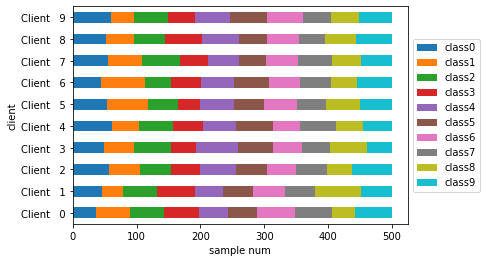

In [19]:
# perform partition
iid_part = FMNISTPartitioner(trainset.targets, 
                            num_clients=num_clients,
                            partition="iid",
                            seed=1)
# generate partition report
csv_file = "data/CIFAR10/cifar10_iid_clients_10.csv"
partition_report(trainset.targets, iid_part.client_dict, 
                 class_num=num_classes, 
                 verbose=False, file=csv_file)

iid_part_df = pd.read_csv(csv_file,header=1)
iid_part_df = iid_part_df.set_index('client')
for col in col_names:
    iid_part_df[col] = (iid_part_df[col] * iid_part_df['Amount']).astype(int)

# select first 10 clients for bar plot
iid_part_df[col_names].iloc[:10].plot.barh(stacked=True)  
# plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('sample num')
plt.savefig(f"data/CIFAR10/cifar10_iid_clients_10.png", 
            dpi=400, bbox_inches = 'tight')

In [20]:
dict_users_train_iid = trainset_sampling_label(args, trainset, trainset_sample_rate,rare_class_nums, iid_part) 
dict_users_test_iid = testset_sampling(args, testset, number_perclass, iid_part_df)

In [21]:
training_number = {j:{}  for j in range(args.K)}

for i in range(args.K):
    training_number[i] = {j: 0 for  j in range(num_classes)}
    label_class = set (np.array(trainset.targets)[list(dict_users_train_iid[i])].tolist())
    #print(list(label_class))
    for k in label_class:
        training_number[i][k] = list(np.array(trainset.targets)[list(dict_users_train_iid[i])]).count(k)

In [22]:
df_training_number=[]
df_training_number=pd.DataFrame(df_training_number)
for i in range(args.K):
    temp = pd.Series(training_number[i])
    df_training_number[i]= temp
    
df_training_number['Col_sum'] = df_training_number.apply(lambda x: x.sum(), axis=1)
df_training_number.loc['Row_sum'] = df_training_number.apply(lambda x: x.sum())

df_training_number

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Col_sum
0,36,45,57,48,61,53,44,55,52,59,...,50,54,43,42,47,61,47,48,62,5000
1,54,34,48,47,43,64,69,53,44,36,...,43,53,51,42,48,45,49,42,51,5000
2,52,53,49,58,53,48,40,60,48,54,...,59,49,57,45,44,47,45,62,48,5000
3,55,59,45,40,47,35,48,44,58,43,...,48,46,57,63,40,49,44,40,44,5000
4,46,45,56,66,51,53,51,49,59,54,...,56,52,49,61,51,45,58,58,45,5000
5,45,46,50,54,58,46,56,42,43,58,...,51,40,48,52,58,52,59,49,49,5000
6,60,50,44,46,43,52,48,50,51,57,...,49,47,49,54,49,45,53,57,53,5000
7,58,48,49,44,57,46,48,54,41,44,...,36,60,53,44,56,51,47,51,50,5000
8,37,72,40,58,42,53,42,45,48,44,...,50,50,50,46,51,58,60,50,48,5000
9,57,48,62,39,45,50,54,48,56,51,...,58,49,43,51,56,47,38,43,50,5000


In [23]:
# initiate the server with defined model and dataset

In [24]:
serverz = server.Server(args, specf_model, trainset, dict_users_train)#dict_users指的是user的local dataset索引

In [25]:
#  baseline----> iid setting with fedavg

In [26]:
server_iid = server.Server(args, specf_model, trainset, dict_users_train_iid)
if Train_model:
    global_model_iid, similarity_dict_iid, client_models_iid, loss_dict_iid, clients_index_iid, acc_list_iid = server_iid.fedavg_joint_update(testset, dict_users_test_iid[0], iid= True, similarity = similarity, test_global_model_accuracy = True)
else:
    if similarity:
        similarity_dict_iid = torch.load("results/Test/label skew/cifar10/iid-fedavg/seed{}/similarity_dict_iid_{}E_{}class.pt".format(args.seed,args.E,C))
    acc_list_iid = torch.load("results/Test/label skew/cifar10/iid-fedavg/seed{}/acc_list_iid_{}E_{}class.pt".format(args.seed,args.E,C))
    global_model_iid = server_iid.nn
    client_models_iid = server_iid.nns
    path_iid_fedavg = "results/Test/label skew/cifar10/iid-fedavg/seed{}/global_model_iid-fedavg_{}E_{}class.pt".format(args.seed,args.E,C)
    global_model_iid.load_state_dict(torch.load(path_iid_fedavg))
    for i in range(args.K):
        path_iid_fedavg = "results/Test/label skew/cifar10/iid-fedavg/seed{}/client{}_model_fedavg_{}E_{}class".format(args.seed,i,args.E,C)
        client_models_iid[i]=copy.deepcopy(global_model_iid)
        client_models_iid[i].load_state_dict(torch.load(path_iid_fedavg))

round 1 :
tensor(11.1700)
round 2 :
tensor(15.8400)
round 3 :
tensor(17.2400)
round 4 :
tensor(20.4000)
round 5 :
tensor(21.8000)
round 6 :
tensor(25.9300)
round 7 :
tensor(26.7300)
round 8 :
tensor(28.5700)
round 9 :
tensor(28.5800)
round 10 :
tensor(30.0900)
round 11 :
tensor(30.4700)
round 12 :
tensor(32.4300)
round 13 :
tensor(32.4200)
round 14 :
tensor(33.0200)
round 15 :
tensor(34.2800)
round 16 :
tensor(34.5800)
round 17 :
tensor(35.7800)
round 18 :
tensor(36.3500)
round 19 :
tensor(37.1800)
round 20 :
tensor(37.7600)
round 21 :
tensor(38.0500)
round 22 :
tensor(38.4700)
round 23 :
tensor(39.0700)
round 24 :
tensor(39.6900)
round 25 :
tensor(40.0300)
round 26 :
tensor(40.6200)
round 27 :
tensor(41.0800)
round 28 :
tensor(41.7300)
round 29 :
tensor(42.0500)
round 30 :
tensor(42.4400)
round 31 :
tensor(42.6100)
round 32 :
tensor(43.0500)
round 33 :
tensor(43.4300)
round 34 :
tensor(43.5700)
round 35 :
tensor(44.1400)
round 36 :
tensor(44.2900)
round 37 :
tensor(44.6300)
round 38 :

In [27]:
if save_models:
    if similarity:
        torch.save(similarity_dict_iid,"results/Test/label skew/cifar10/iid-fedavg/seed{}/similarity_dict_iid_{}E_{}class.pt".format(args.seed,args.E,C))
    torch.save(acc_list_iid,"results/Test/label skew/cifar10/iid-fedavg/seed{}/acc_list_iid_{}E_{}class.pt".format(args.seed,args.E,C))
    path_iid_fedavg = "results/Test/label skew/cifar10/iid-fedavg/seed{}/global_model_iid-fedavg_{}E_{}class.pt".format(args.seed,args.E,C)
    torch.save(global_model_iid.state_dict(), path_iid_fedavg)

In [28]:
g_iid,_ = test_on_globaldataset(args, global_model_iid, testset)
g_iid

tensor(59.9900)

In [29]:
a_iid,_ =globalmodel_test_on_localdataset(args,global_model_iid, testset,dict_users_test_iid)
np.mean(list(a_iid.values()))

61.01

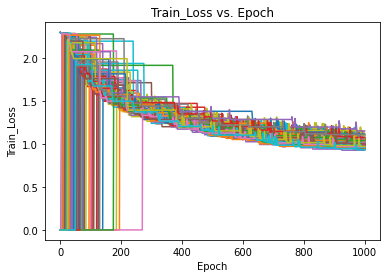

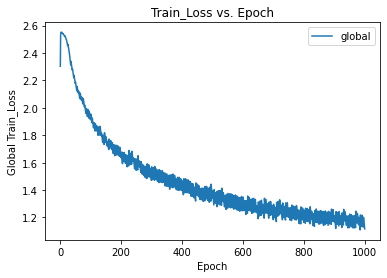

In [30]:
if Train_model:
    train_loss_show(args, loss_dict_iid,clients_index_iid)

In [31]:
#  baseline---->fedavg

In [32]:
server_fedavg =  copy.deepcopy(serverz)#dict_users指的是user的local dataset索引

if Train_model:
    global_model1, similarity_dict1, client_models1, loss_dict1, clients_index1, acc_list1 = server_fedavg.fedavg_joint_update(testset, dict_users_test_iid[0],similarity = similarity,test_global_model_accuracy = True)
else:
    if similarity:
        similarity_dict1 = torch.load("results/Test/label skew/cifar10/fedavg/seed{}/similarity_dict1_{}E_{}class.pt".format(args.seed,args.E,C))
    acc_list1 = torch.load("results/Test/label skew/cifar10/fedavg/seed{}/acc_list1_{}E_{}class.pt".format(args.seed,args.E,C))
    global_model1 = server_fedavg.nn
    client_models1 = server_fedavg.nns
    path_fedavg = "results/Test/label skew/cifar10/fedavg/seed{}/global_model_fedavg_{}E_{}class.pt".format(args.seed,args.E,C)
    global_model1.load_state_dict(torch.load(path_fedavg))
    for i in range(args.K):
        path_fedavg = "results/Test/label skew/cifar10/fedavg/seed{}/client{}_model_fedavg_{}E_{}class".format(args.seed,i,args.E,C)
        client_models1[i]=copy.deepcopy(global_model1)
        client_models1[i].load_state_dict(torch.load(path_fedavg))

round 1 :
tensor(10.)
round 2 :
tensor(10.)
round 3 :
tensor(11.7200)
round 4 :
tensor(10.0500)
round 5 :
tensor(10.4700)
round 6 :
tensor(16.8900)
round 7 :
tensor(17.7800)
round 8 :
tensor(15.0700)
round 9 :
tensor(15.2100)
round 10 :
tensor(18.9600)
round 11 :
tensor(15.1700)
round 12 :
tensor(16.1500)
round 13 :
tensor(23.6000)
round 14 :
tensor(16.8200)
round 15 :
tensor(13.5200)
round 16 :
tensor(17.8900)
round 17 :
tensor(20.8600)
round 18 :
tensor(20.8100)
round 19 :
tensor(16.5700)
round 20 :
tensor(25.4200)
round 21 :
tensor(24.3700)
round 22 :
tensor(20.4400)
round 23 :
tensor(20.3300)
round 24 :
tensor(18.3700)
round 25 :
tensor(24.5200)
round 26 :
tensor(28.6400)
round 27 :
tensor(28.4600)
round 28 :
tensor(24.5800)
round 29 :
tensor(24.9900)
round 30 :
tensor(29.2200)
round 31 :
tensor(30.2100)
round 32 :
tensor(26.4300)
round 33 :
tensor(26.2800)
round 34 :
tensor(29.8000)
round 35 :
tensor(31.0600)
round 36 :
tensor(23.3900)
round 37 :
tensor(27.9000)
round 38 :
tensor(

In [33]:
if save_models:
    if similarity:
        torch.save(similarity_dict1,"results/Test/label skew/cifar10/iid-fedavg/seed{}/similarity_dict1_{}E_{}class.pt".format(args.seed,args.E,C))
    torch.save(acc_list1,"results/Test/label skew/cifar10/fedavg/seed{}/acc_list1_{}E_{}class.pt".format(args.seed,args.E,C))
    path_fedavg = "results/Test/label skew/cifar10/fedavg/seed{}/global_model_fedavg_{}E_{}class.pt".format(args.seed,args.E,C)
    torch.save(global_model1.state_dict(), path_fedavg)

In [34]:
g1,_ = test_on_globaldataset(args, global_model1, testset)
g1

tensor(34.7400)

In [35]:
a1,_ =globalmodel_test_on_localdataset(args,global_model1, testset,dict_users_test)
np.mean(list(a1.values()))

33.85

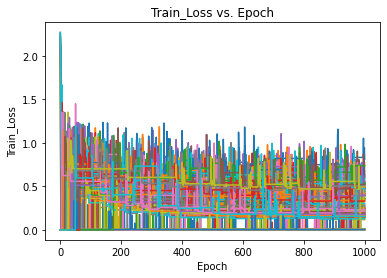

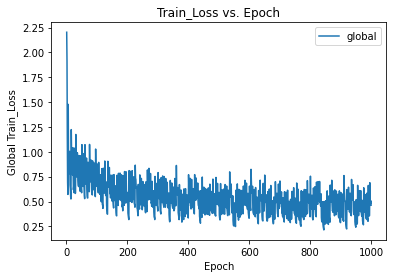

In [36]:
if Train_model:
    train_loss_show(args, loss_dict1,clients_index1)
#train_localacc_show(args, mean_local_accuracy_list1)

In [37]:
#  baseline---->fedprox

In [38]:
server_fedprox_joint = copy.deepcopy(serverz)

if Train_model:
    global_modelp, similarity_dictp, client_modelsp, loss_dictp, clients_indexp, acc_listp = server_fedprox_joint.fedprox_joint_update(testset, dict_users_test_iid[0],similarity = similarity, test_global_model_accuracy = True)
else:
    if similarity:
        similarity_dictp = torch.load("results/Test/label skew/cifar10/fedprox/seed{}/similarity_dictp_{}E_{}class.pt".format(args.seed,args.E,C))
    acc_listp = torch.load("results/Test/label skew/cifar10/fedprox/seed{}/acc_listp_{}E_{}class.pt".format(args.seed,args.E,C))
    global_modelp = server_fedprox_joint.nn
    client_modelsp = server_fedprox_joint.nns
    path_fedprox = "results/Test/label skew/cifar10/fedprox/seed{}/global_model_fedprox_{}E_{}class.pt".format(args.seed,args.E,C)
    global_modelp.load_state_dict(torch.load(path_fedprox))
    for i in range(args.K):
        path_fedprox = "results/Test/label skew/cifar10/fedprox/seed{}/client{}_model_fedprox_{}E_{}class".format(args.seed,i,args.E,C)
        client_modelsp[i] = copy.deepcopy(global_modelp)
        client_modelsp[i].load_state_dict(torch.load(path_fedprox))

round 1 :
tensor(10.)
round 2 :
tensor(10.)
round 3 :
tensor(10.7400)
round 4 :
tensor(10.0100)
round 5 :
tensor(10.2300)
round 6 :
tensor(14.6800)
round 7 :
tensor(17.4800)
round 8 :
tensor(15.8300)
round 9 :
tensor(15.4900)
round 10 :
tensor(22.0400)
round 11 :
tensor(15.1300)
round 12 :
tensor(16.7800)
round 13 :
tensor(23.3700)
round 14 :
tensor(16.3500)
round 15 :
tensor(13.9300)
round 16 :
tensor(17.9200)
round 17 :
tensor(21.6900)
round 18 :
tensor(22.1700)
round 19 :
tensor(16.5000)
round 20 :
tensor(25.5900)
round 21 :
tensor(24.2000)
round 22 :
tensor(19.8500)
round 23 :
tensor(20.3200)
round 24 :
tensor(18.5000)
round 25 :
tensor(25.0500)
round 26 :
tensor(29.1100)
round 27 :
tensor(28.8600)
round 28 :
tensor(25.6700)
round 29 :
tensor(26.3300)
round 30 :
tensor(29.0900)
round 31 :
tensor(29.4700)
round 32 :
tensor(26.9900)
round 33 :
tensor(25.0100)
round 34 :
tensor(30.0300)
round 35 :
tensor(31.3500)
round 36 :
tensor(23.4300)
round 37 :
tensor(26.1800)
round 38 :
tensor(

In [39]:
if save_models:
    if similarity:
        torch.save(similarity_dictp,"results/Test/label skew/cifar10/iid-fedavg/seed{}/similarity_dictp_{}E_{}class.pt".format(args.seed,args.E,C))
    torch.save(acc_listp,"results/Test/label skew/cifar10/fedprox/seed{}/acc_listp_{}E_{}class.pt".format(args.seed,args.E,C))
    path_fedprox = "results/Test/label skew/cifar10/fedprox/seed{}/global_model_fedprox_{}E_{}class.pt".format(args.seed,args.E,C)
    torch.save(global_modelp.state_dict(), path_fedprox)

In [40]:
gp,_ = test_on_globaldataset(args, global_modelp, testset)
gp

tensor(33.4200)

In [41]:
ap,_ =globalmodel_test_on_localdataset(args,global_modelp, testset,dict_users_test)
np.mean(list(ap.values()))

32.2

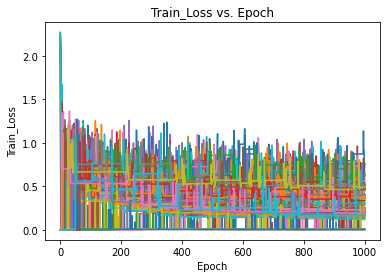

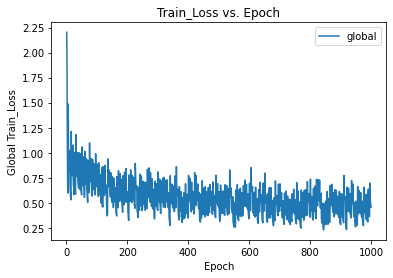

In [42]:
if Train_model:
    train_loss_show(args, loss_dictp,clients_indexp)

In [43]:
#  baseline---->feddyn

In [44]:
server_feddyn = copy.deepcopy(serverz)
if Train_model:
    global_modeldyn, similarity_dictdyn, client_modelsdyn, loss_dictdyn, clients_indexdyn, acc_listdyn = server_feddyn.feddyn(testset, dict_users_test_iid[0],similarity = similarity, test_global_model_accuracy = True)
else:
    if similarity:
        similarity_dictdyn = torch.load("results/Test/label skew/cifar10/feddyn/seed{}/similarity_dictdyn_{}E_{}class.pt".format(args.seed,args.E,C))
    acc_listdyn = torch.load("results/Test/label skew/cifar10/feddyn/seed{}/acc_listdyn_{}E_{}class.pt".format(args.seed,args.E,C))
    global_modeldyn = server_feddyn.nn
    client_modelsdyn = server_feddyn.nns
    path_feddyn = "results/Test/label skew/cifar10/feddyn/seed{}/global_model_feddyn_{}E_{}class.pt".format(args.seed,args.E,C)
    global_modeldyn.load_state_dict(torch.load(path_feddyn))
    for i in range(args.K):
        path_feddyn = "results/Test/label skew/cifar10/feddyn/seed{}/client{}_model_feddyn_{}E_{}class".format(args.seed,i,args.E,C)
        client_modelsdyn[i] = copy.deepcopy(global_modeldyn)
        client_modelsdyn[i].load_state_dict(torch.load(path_feddyn))

round 1 :
tensor(10.)
round 2 :
tensor(10.)
round 3 :
tensor(11.1000)
round 4 :
tensor(10.0100)
round 5 :
tensor(10.2900)
round 6 :
tensor(16.7300)
round 7 :
tensor(15.9300)
round 8 :
tensor(15.5700)
round 9 :
tensor(16.5900)
round 10 :
tensor(22.0300)
round 11 :
tensor(16.3600)
round 12 :
tensor(14.7300)
round 13 :
tensor(22.6000)
round 14 :
tensor(16.4100)
round 15 :
tensor(13.7100)
round 16 :
tensor(18.5100)
round 17 :
tensor(22.2900)
round 18 :
tensor(22.5500)
round 19 :
tensor(16.6600)
round 20 :
tensor(25.2500)
round 21 :
tensor(24.7800)
round 22 :
tensor(21.6400)
round 23 :
tensor(20.8300)
round 24 :
tensor(18.9800)
round 25 :
tensor(24.7900)
round 26 :
tensor(29.7500)
round 27 :
tensor(29.4000)
round 28 :
tensor(27.0100)
round 29 :
tensor(26.3300)
round 30 :
tensor(29.4100)
round 31 :
tensor(28.8700)
round 32 :
tensor(27.1400)
round 33 :
tensor(27.1000)
round 34 :
tensor(31.3600)
round 35 :
tensor(31.7900)
round 36 :
tensor(23.8900)
round 37 :
tensor(29.9700)
round 38 :
tensor(

In [45]:
if save_models:
    if similarity:
        torch.save(similarity_dictdyn,"results/Test/label skew/cifar10/iid-fedavg/seed{}/similarity_dictdyn_{}E_{}class.pt".format(args.seed,args.E,C))
    torch.save(acc_listdyn,"results/Test/label skew/cifar10/feddyn/seed{}/acc_listdyn_{}E_{}class.pt".format(args.seed,args.E,C))
    path_feddyn = "results/Test/label skew/cifar10/feddyn/seed{}/global_model_feddyn_{}E_{}class.pt".format(args.seed,args.E,C)
    torch.save(global_modeldyn.state_dict(), path_feddyn)

In [46]:
gdyn,_ = test_on_globaldataset(args, global_modeldyn, testset)
gdyn

tensor(32.5100)

In [47]:
adyn,_ =globalmodel_test_on_localdataset(args,global_modeldyn, testset,dict_users_test)
np.mean(list(adyn.values()))

30.9

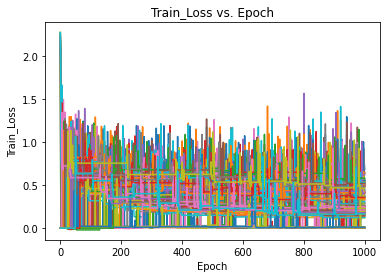

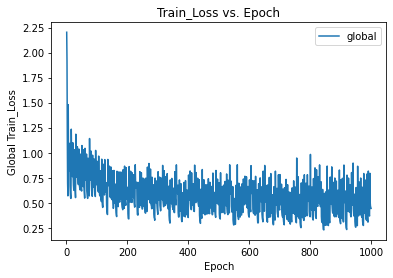

In [48]:
if Train_model:
    train_loss_show(args, loss_dictdyn,clients_indexdyn)

In [49]:
#  baseline---->moon

In [50]:
server_moon = copy.deepcopy(serverz)
if Train_model:
    global_modelm, similarity_dictm, client_modelsm, loss_dictm, clients_indexm, acc_listm = server_moon.moon(testset, dict_users_test_iid[0],similarity = similarity, test_global_model_accuracy = True)
else:
    if similarity:
        similarity_dictm = torch.load("results/Test/label skew/cifar10/moon/seed{}/similarity_dictm_{}E_{}class.pt".format(args.seed,args.E,C))
    acc_listm = torch.load("results/Test/label skew/cifar10/moon/seed{}/acc_listm_{}E_{}class.pt".format(args.seed,args.E,C))
    global_modelm = server_moon.nn
    client_modelsm = server_moon.nns
    path_moon = "results/Test/label skew/cifar10/moon/seed{}/global_model_moon_{}E_{}class.pt".format(args.seed,args.E,C)
    global_modelm.load_state_dict(torch.load(path_moon))
    for i in range(args.K):
        path_moon = "results/Test/label skew/cifar10/moon/seed{}/client{}_model_moon_{}E_{}class".format(args.seed,i,args.E,C)
        client_modelsm[i] = copy.deepcopy(global_modelm)
        client_modelsm[i].load_state_dict(torch.load(path_moon))

round 1 :
tensor(10.)
round 2 :
tensor(10.)
round 3 :
tensor(13.0900)
round 4 :
tensor(10.4200)
round 5 :
tensor(10.)
round 6 :
tensor(15.3000)
round 7 :
tensor(19.1100)
round 8 :
tensor(17.1500)
round 9 :
tensor(13.8400)
round 10 :
tensor(19.2800)
round 11 :
tensor(16.3400)
round 12 :
tensor(14.8700)
round 13 :
tensor(21.1000)
round 14 :
tensor(16.2100)
round 15 :
tensor(13.5800)
round 16 :
tensor(17.6800)
round 17 :
tensor(19.5900)
round 18 :
tensor(20.4800)
round 19 :
tensor(16.2600)
round 20 :
tensor(23.4300)
round 21 :
tensor(22.5000)
round 22 :
tensor(17.9000)
round 23 :
tensor(15.4700)
round 24 :
tensor(16.4800)
round 25 :
tensor(22.4900)
round 26 :
tensor(27.4800)
round 27 :
tensor(25.8800)
round 28 :
tensor(23.9700)
round 29 :
tensor(22.5200)
round 30 :
tensor(26.7600)
round 31 :
tensor(22.4600)
round 32 :
tensor(22.9200)
round 33 :
tensor(21.6200)
round 34 :
tensor(25.4500)
round 35 :
tensor(25.9300)
round 36 :
tensor(17.9700)
round 37 :
tensor(22.8700)
round 38 :
tensor(17.9

In [51]:
if save_models:
    if similarity:
        torch.save(similarity_dictm,"results/Test/label skew/cifar10/iid-fedavg/seed{}/similarity_dictm_{}E_{}class.pt".format(args.seed,args.E,C))
    torch.save(acc_listm,"results/Test/label skew/cifar10/moon/seed{}/acc_listm_{}E_{}class.pt".format(args.seed,args.E,C))
    path_moon = "results/Test/label skew/cifar10/moon/seed{}/global_model_moon_{}E_{}class.pt".format(args.seed,args.E,C)
    torch.save(global_modelm.state_dict(), path_moon)

In [52]:
gm,_ = test_on_globaldataset(args, global_modelm, testset)
gm

tensor(31.9300)

In [53]:
am,_ =globalmodel_test_on_localdataset(args,global_modelm, testset,dict_users_test)
np.mean(list(am.values()))

30.95

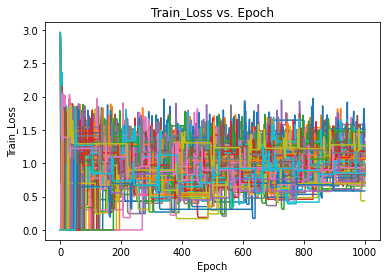

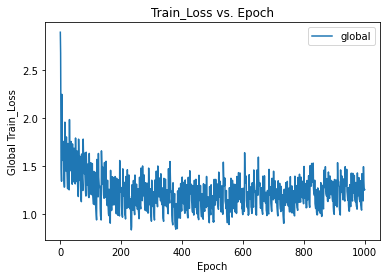

In [54]:
if Train_model:
    train_loss_show(args, loss_dictm,clients_indexm)

In [55]:
#  baseline---->fedproc

In [56]:
server_fedproc =  copy.deepcopy(serverz)
if Train_model:
    global_modelproc, similarity_dictproc, client_modelsproc, loss_dictproc, clients_indexproc, acc_listproc= server_fedproc.fedproc(testset, dict_users_test_iid[0],similarity = similarity, test_global_model_accuracy = True)
else:
    if similarity:
        similarity_dictproc = torch.load("results/Test/label skew/cifar10/fedproc/seed{}/similarity_dictproc_{}E_{}class.pt".format(args.seed,args.E,C))
    acc_listproc = torch.load("results/Test/label skew/cifar10/fedproc/seed{}/acc_listproc_{}E_{}class.pt".format(args.seed,args.E,C))
    global_modelproc = server_fedproc.nn
    client_modelsproc = server_fedproc.nns
    path_fedproc = "results/Test/label skew/cifar10/fedproc/seed{}/global_model_fedproc_{}E_{}class.pt".format(args.seed,args.E,C)
    global_modelproc.load_state_dict(torch.load(path_fedproc))
    for i in range(args.K):
        path_fedproc = "results/Test/label skew/cifar10/fedproc/seed{}/client{}_model_fedproc_{}E_{}class".format(args.seed,i,args.E,C)
        client_modelsproc[i]=copy.deepcopy(global_modelproc)
        client_modelsproc[i].load_state_dict(torch.load(path_fedproc))

round 1 :
tensor(9.5700)
round 2 :
tensor(10.0200)
round 3 :
tensor(10.)
round 4 :
tensor(9.8900)
round 5 :
tensor(11.2000)
round 6 :
tensor(10.9200)
round 7 :
tensor(10.7200)
round 8 :
tensor(13.9200)
round 9 :
tensor(14.5300)
round 10 :
tensor(19.2900)
round 11 :
tensor(13.9300)
round 12 :
tensor(19.0500)
round 13 :
tensor(19.9300)
round 14 :
tensor(15.3900)
round 15 :
tensor(11.0900)
round 16 :
tensor(15.6800)
round 17 :
tensor(19.4600)
round 18 :
tensor(16.5700)
round 19 :
tensor(16.2100)
round 20 :
tensor(26.1700)
round 21 :
tensor(24.5000)
round 22 :
tensor(18.0300)
round 23 :
tensor(19.1400)
round 24 :
tensor(19.9000)
round 25 :
tensor(23.5400)
round 26 :
tensor(23.7300)
round 27 :
tensor(29.1700)
round 28 :
tensor(22.9900)
round 29 :
tensor(24.7900)
round 30 :
tensor(30.2400)
round 31 :
tensor(29.5700)
round 32 :
tensor(27.6300)
round 33 :
tensor(26.4700)
round 34 :
tensor(29.2400)
round 35 :
tensor(30.4800)
round 36 :
tensor(18.9900)
round 37 :
tensor(25.0300)
round 38 :
tenso

In [57]:
if save_models:
    if similarity:
        torch.save(similarity_dictproc,"results/Test/label skew/cifar10/iid-fedavg/seed{}/similarity_dictproc_{}E_{}class.pt".format(args.seed,args.E,C))
    torch.save(acc_listproc,"results/Test/label skew/cifar10/fedproc/seed{}/acc_listproc_{}E_{}class.pt".format(args.seed,args.E,C))
    path_fedproc = "results/Test/label skew/cifar10/fedproc/seed{}/global_model_fedproc_{}E_{}class.pt".format(args.seed,args.E,C)
    torch.save(global_modelproc.state_dict(), path_fedproc)

In [58]:
gproc,_ = test_on_globaldataset(args, global_modelproc, testset)
gproc

tensor(32.6300)

In [59]:
aproc,_ =globalmodel_test_on_localdataset(args,global_modelproc, testset,dict_users_test)
np.mean(list(aproc.values()))

32.15

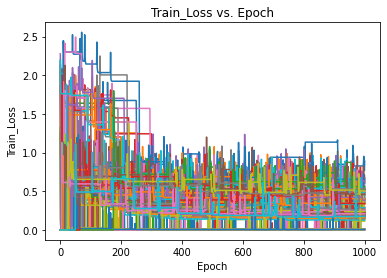

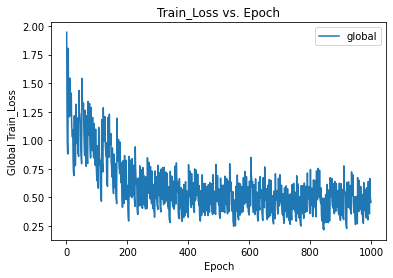

In [60]:
if Train_model:
    train_loss_show(args, loss_dictproc,clients_indexproc)

In [61]:
#fedfa

In [62]:
server_feature = copy.deepcopy(serverz)

In [63]:
if Train_model:
    global_modelfa, similarity_dictfa, client_modelsfa, loss_dictfa, clients_indexfa, acc_listfa = server_feature.fedfa_anchorloss(testset, dict_users_test_iid[0],
                                                                                                                   similarity = similarity,
                                                                                                             test_global_model_accuracy = True)
else:
    if similarity:
        similarity_dictfa = torch.load("results/Test/label skew/cifar10/fedfa/seed{}/similarity_dictfa_{}E_{}class.pt".format(args.seed,args.E,C))
    acc_listfa = torch.load("results/Test/label skew/cifar10/fedfa/seed{}/acc_listfa_{}E_{}class.pt".format(args.seed,args.E,C))
    global_modelfa = server_feature.nn
    client_modelsfa = server_feature.nns
    path_fedfa = "results/Test/label skew/cifar10/fedfa/seed{}/global_model_fedfa_{}E_{}class".format(args.seed,args.E,C)
    global_modelfa.load_state_dict(torch.load(path_fedfa))
    for i in range(args.K):
        path_fedfa = "results/Test/label skew/cifar10/fedfa/seed{}/client{}_model_fedfa_{}E_{}class".format(args.seed,i,args.E,C)
        client_modelsfa[i] = copy.deepcopy(global_modelfa)
        client_modelsfa[i].load_state_dict(torch.load(path_fedfa))

round 1 :
tensor(10.0100)
round 2 :
tensor(12.2100)
round 3 :
tensor(18.7400)
round 4 :
tensor(14.3800)
round 5 :
tensor(17.2300)
round 6 :
tensor(26.3400)
round 7 :
tensor(24.5600)
round 8 :
tensor(23.2400)
round 9 :
tensor(25.0700)
round 10 :
tensor(30.2400)
round 11 :
tensor(20.8600)
round 12 :
tensor(27.6700)
round 13 :
tensor(33.3600)
round 14 :
tensor(26.6700)
round 15 :
tensor(27.8600)
round 16 :
tensor(24.9400)
round 17 :
tensor(31.5100)
round 18 :
tensor(33.7100)
round 19 :
tensor(23.8700)
round 20 :
tensor(36.0100)
round 21 :
tensor(33.7800)
round 22 :
tensor(30.1700)
round 23 :
tensor(33.6000)
round 24 :
tensor(29.5500)
round 25 :
tensor(37.7900)
round 26 :
tensor(40.4100)
round 27 :
tensor(41.8800)
round 28 :
tensor(41.7400)
round 29 :
tensor(38.9300)
round 30 :
tensor(40.8100)
round 31 :
tensor(45.7200)
round 32 :
tensor(44.0900)
round 33 :
tensor(43.0500)
round 34 :
tensor(43.5600)
round 35 :
tensor(42.2700)
round 36 :
tensor(36.9100)
round 37 :
tensor(44.1500)
round 38 :

In [64]:
if save_models:
    if similarity:
        torch.save(similarity_dictfa,"results/Test/label skew/cifar10/iid-fedavg/seed{}/similarity_dictfa_{}E_{}class.pt".format(args.seed,args.E,C))
    torch.save(acc_listfa,"results/Test/label skew/cifar10/fedfa/seed{}/acc_listfa_{}E_{}class.pt".format(args.seed,args.E,C))
    path_fedfa = "results/Test/label skew/cifar10/fedfa/seed{}/global_model_fedfa_{}E_{}class".format(args.seed,args.E,C)
    torch.save(global_modelfa.state_dict(), path_fedfa)

In [65]:
gfa,_ = test_on_globaldataset(args, global_modelfa, testset)
gfa

tensor(51.0500)

In [66]:
afa,_ =globalmodel_test_on_localdataset(args,global_modelfa, testset,dict_users_test)
np.mean(list(afa.values()))

50.0

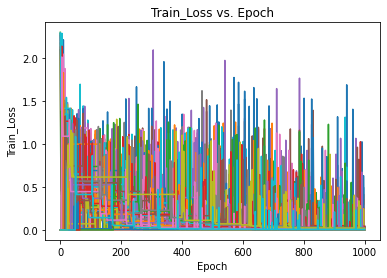

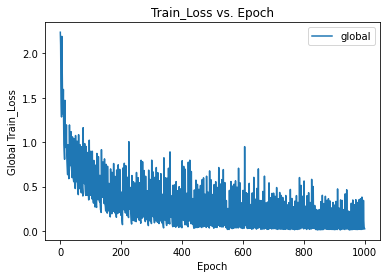

In [67]:
if Train_model:
    train_loss_show(args, loss_dictfa, clients_indexfa)